In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import time

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias
from exp_hp import get_hp

2024-08-14 11:09:29.786788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 11:09:30.477548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-08-14 11:09:32.409500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 861 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


### Load standardized CESM2-LE

In [3]:
EXP_NAME = 'exp2' 
hps = get_hp(EXP_NAME)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

_, _, X1test, _, _, Y1test, inew = split_SDbias(trainmems = hps['train_mems'],
                                                  valmem = hps['val_mems'][0],
                                                  testmem = hps['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps['LEAD'])

GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
files do not exist - loading data & saving


### Test NN

0


2024-08-14 11:09:44.427070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 861 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-08-14 11:09:44.884820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-08-14 11:09:45.025356: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-14 11:09:45.074925: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 601.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


115/235 [=============>................] - ETA: 0s

2024-08-14 11:09:45.087740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


235/235 [==============================] - 1s 2ms/step


2024-08-14 11:09:45.464517: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-14 11:09:45.516559: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


1
235/235 [==============================] - 0s 2ms/step
2
235/235 [==============================] - 0s 1ms/step
3
235/235 [==============================] - 0s 1ms/step
4
235/235 [==============================] - 1s 2ms/step
5
235/235 [==============================] - 1s 2ms/step
6
235/235 [==============================] - 0s 1ms/step
7
235/235 [==============================] - 0s 1ms/step
8
235/235 [==============================] - 0s 2ms/step
9
235/235 [==============================] - 0s 2ms/step


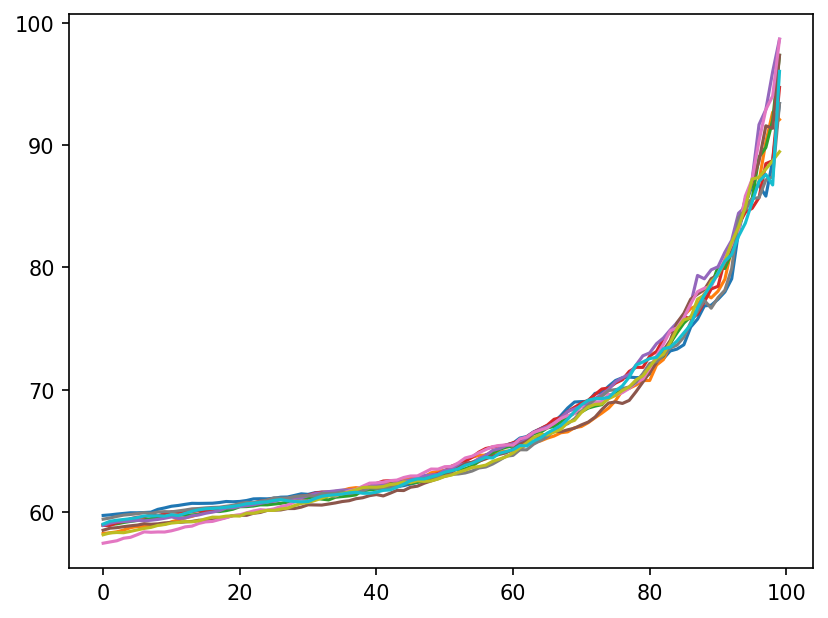

In [4]:
#----- SET UP & TRAIN NN -----
acc_all = []
for SEED in range(10):
    print(SEED)
    cnnfi_name = 'cnn1_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    cnn = tf.keras.models.load_model(base_dir+'CNNcheck/saved_models/'+cnnfi_name)
    
    pred = cnn.predict(X1test)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == Y1test[iconf])
        
        acc.append((len(icorr[0])/len(iconf[0]))*100)
    plt.plot(acc)
    
    acc_all.append(acc)

np.save(base_dir+'CNNcheck/confvsacc/confvsacc_cnn1_60Eshift_'+EXP_NAME+'.npy', acc_all, allow_pickle=True)